In [1]:
import os
import winsound
import numpy as np
import pandas as pd
import datetime as dt
from tqdm import tqdm
tqdm.pandas()
from multiprocessing import  Pool
import time

import math, collections
from scipy.stats import linregress

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_live = pd.read_csv('data\live_preds.csv')
df = df_live[['tick_avg']]
df_live.head()

,predicted_direction,tick_avg,spread_avg,tick_sd,diff,avg_gain,avg_loss,rs,rsi,sema,...,lema,lema_diff,lsma,lsma_diff,ema_diff,sma_diff,max_tick,min_tick,max_gap,min_gap
0,same,1.228242,0.000080,0.000075,0.000214,0.000037,0.000029,1.271766,55.981385,1.228130,...,1.228273,-3.499938e-07,1.228346,0.000003,-0.000143,-0.000195,1.228277,1.228026,0.000035,-0.000215
1,same,1.228369,0.000082,0.000044,0.000127,0.000046,0.000025,1.826305,64.618108,1.228155,...,1.228278,5.027293e-06,1.228350,0.000004,-0.000123,-0.000192,1.228369,1.228026,0.000000,-0.000343
2,same,1.228499,0.000085,0.000032,0.000130,0.000052,0.000025,2.097212,67.712901,1.228193,...,1.228289,1.066024e-05,1.228356,0.000006,-0.000096,-0.000180,1.228499,1.228026,0.000000,-0.000472
3,same,1.228562,0.000075,0.000038,0.000063,0.000052,0.000025,2.070765,67.434823,1.228232,...,1.228301,1.285945e-05,1.228363,0.000007,-0.000069,-0.000173,1.228562,1.228026,0.000000,-0.000535
4,same,1.228641,0.000071,0.000016,0.000079,0.000051,0.000025,2.057184,67.290157,1.228277,...,1.228317,1.575233e-05,1.228371,0.000008,-0.000040,-0.000161,1.228641,1.228026,0.000000,-0.000614


In [3]:
df['diff'] = df['tick_avg'].diff()
df['gain'] = 0
df['loss'] = 0
df['gain'].loc[df['diff'] > 0] = abs(df['diff'])
df['loss'].loc[df['diff'] < 0] = abs(df['diff'])
df['avg_gain'] = df['gain'].rolling(window=14).mean()
df['avg_loss'] = df['loss'].rolling(window=14).mean()
df['ssma'] = df['tick_avg'].rolling(window=20).mean()
df['ssma_diff'] = df['ssma'].diff()
df['lsma'] = df['tick_avg'].rolling(window=50).mean()
df['lsma_diff'] = df['lsma'].diff()
df['sma_diff'] = df['ssma'] - df['lsma']

del df['gain']
del df['loss']
df = df.dropna()
#df = df.reset_index(drop=True)

In [4]:
data = {}
data['sma_len'] = 20

data['ssma_list'] = collections.deque([])
data['sema_ready'] = collections.deque([])

df['sema'] = ''
df['sema_diff'] = ''

In [5]:
def before_sma():
    global data    
    data['ssma_list'].append(row['tick_avg'])    
    return()

def after_sma():
    global data
    
    data['ssma_list'].popleft()
    data['ssma_list'].append(row['tick_avg'])
    data['sema'] = list(pd.DataFrame(list(data['ssma_list'])).ewm(span=data['sma_len']).mean()[0])[data['sma_len'] - 1]
    
    if len(data['sema_ready']) < 2:
        data['sema_ready'].append(data['sema'])
        data['sema_diff'] = np.nan

    elif len(data['sema_ready']) > 1:
        data['sema_ready'].popleft()
        data['sema_ready'].append(data['sema'])
        data['sema_diff'] = data['sema_ready'][-1] - data['sema_ready'][len(data['sema_ready'])-2]
    
    return()

In [7]:
for i, row in df.iterrows():
    # Build SMA ---------------------------------------------
    if len(data['ssma_list']) < data['sma_len']:
        before_sma()          
    elif len(data['ssma_list']) == data['sma_len']:
        after_sma() a
        df['sema'][i] = data['sema']
        df['sema_diff'][i]= data['sema_diff']

In [8]:
data['sema_diff']

-1.720462454080085e-05

In [9]:
df.tail()

,tick_avg,diff,avg_gain,avg_loss,ssma,ssma_diff,lsma,lsma_diff,sma_diff,sema,sema_diff
278,1.227101,-0.000009,0.000049,0.000019,1.226865,0.000013,1.226907,-0.000005,-0.000041,1.22693,2.26338e-05
279,1.227039,-0.000062,0.000045,0.000024,1.226871,0.000006,1.226903,-0.000004,-0.000031,1.22694,1.26617e-05
280,1.226944,-0.000095,0.000045,0.000028,1.226874,0.000003,1.226897,-0.000006,-0.000023,1.22694,1.4523e-06
281,1.226813,-0.000131,0.000045,0.000036,1.226873,-0.000001,1.226892,-0.000005,-0.000019,1.22693,-1.24581e-05
282,1.226750,-0.000063,0.000037,0.000040,1.226872,-0.000001,1.226886,-0.000006,-0.000014,1.22691,-1.72046e-05


TypeError: no numeric data to plot

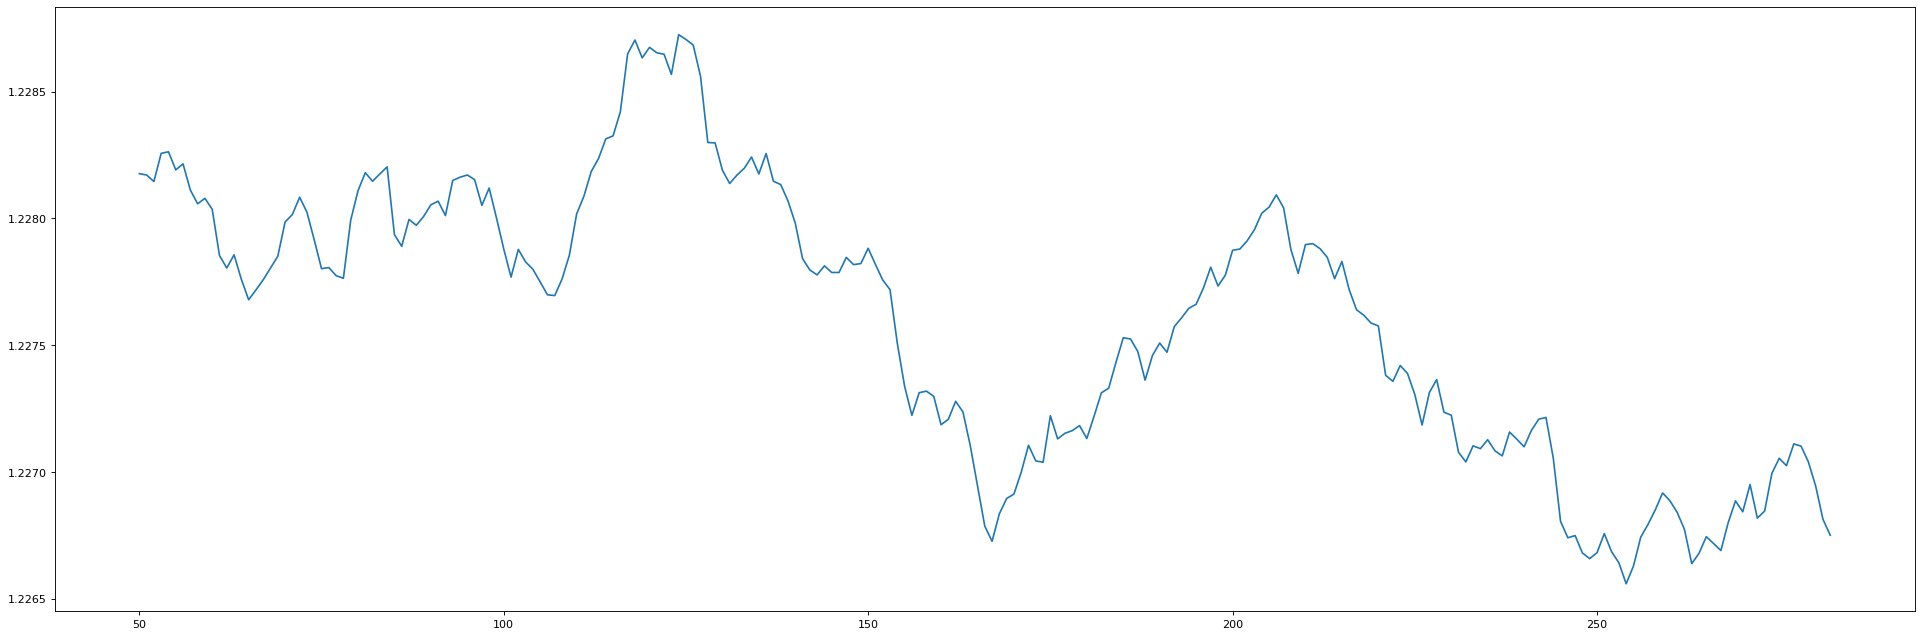

In [10]:
figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
#df_live[df_live.index.isin(list(df.index))]['tick_avg'].plot()

df['tick_avg'].plot(label = 'tick_avg')
df['sema'].plot(label = 'df_pd')
df_live['sema'][50:].plot(label = 'df_live')
plt.legend(loc="upper left")

In [ ]:
#list(pd.DataFrame(list(data['ssma_list'])).ewm(span=data['sma_len']).mean()[0])[data['sma_len'] - 1]